## Convert to Tensorflow

Tensorflow .pb file is used runtime, Keras model needs to be converted. Simply doing:

- Create model to predict.
- Extract tensorflow .pb from the model

This is just following it.

https://qiita.com/cvusk/items/a2a0a11815de491cf3e5

In [1]:
import sys
sys.path.append('../..')
from common import *
%matplotlib inline


Using TensorFlow backend.


## Create model and confirm it works

In [2]:
model = create_model(conf, conf.num_classes)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 32, 32, 16)   144         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 32, 32, 16)   64          Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 32, 32, 16)   0           bn_Conv1[0][0]                   
__________________________________________________________________________________________________
expanded_c

In [3]:
model.load_weights('model_based_on_fsd_model.h5')

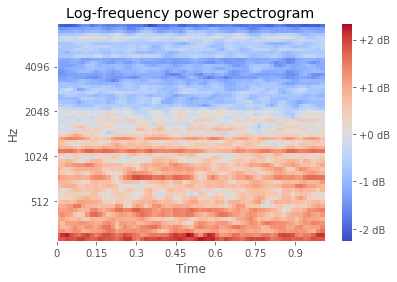

In [4]:
X = load_sample_as_X(conf, 'laser-machine-listener/data/marking/paper_marking.wav')
show_melspectrogram(conf, X[1, ..., -1])

In [5]:
preds = model.predict(X)
for pred in preds:
    result = np.argmax(pred)
    print(conf.labels[result], result)

marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3


## Convert Keras to TF

Thanks to this post, just following it.
https://qiita.com/cvusk/items/a2a0a11815de491cf3e5

In [6]:
# load tensorflow and keras backend
import tensorflow as tf
from tensorflow.python.framework import graph_util
from tensorflow.python.framework import graph_io
from keras import backend as K
ksess = K.get_session()
print(ksess)

# transform keras model to tensorflow graph
# the output will be json-like format
K.set_learning_phase(0)
graph = ksess.graph
kgraph = graph.as_graph_def()
print(kgraph)

node {
  name: "input_1"
  op: "Placeholder"
  attr {
    key: "dtype"
    value {
      type: DT_FLOAT
    }
  }
  attr {
    key: "shape"
    value {
      shape {
        dim {
          size: -1
        }
        dim {
          size: 64
        }
        dim {
          size: 64
        }
        dim {
          size: 1
        }
      }
    }
  }
}
node {
  name: "Conv1/random_uniform/shape"
  op: "Const"
  attr {
    key: "dtype"
    value {
      type: DT_INT32
    }
  }
  attr {
    key: "value"
    value {
      tensor {
        dtype: DT_INT32
        tensor_shape {
          dim {
            size: 4
          }
        }
        tensor_content: "\003\000\000\000\003\000\000\000\001\000\000\000\020\000\000\000"
      }
    }
  }
}
node {
  name: "Conv1/random_uniform/min"
  op: "Const"
  attr {
    key: "dtype"
    value {
      type: DT_FLOAT
    }
  }
  attr {
    key: "value"
    value {
      tensor {
        dtype: DT_FLOAT
        tensor_shape {
        }
        floa

In [7]:
import os
num_output = 1
prefix = "output"
pred = [None]*num_output
outputName = [None]*num_output
for i in range(num_output):
    outputName[i] = prefix + str(i)
    pred[i] = tf.identity(model.get_output_at(i), name=outputName[i])
print('output name: ', outputName)

# convert variables in the model graph to constants
constant_graph = graph_util.convert_variables_to_constants(ksess, ksess.graph.as_graph_def(), outputName)

# save the model in .pb and .txt
output_dir = "./"
output_graph_name = "cnn-model-laser-machine-listener.pb"
output_text_name = "cnn-model-laser-machine-listener.txt"
graph_io.write_graph(constant_graph, output_dir, output_graph_name, as_text=False)
graph_io.write_graph(constant_graph, output_dir, output_text_name, as_text=True)
print('saved graph .pb at: {0}\nsaved graph .txt at: {1}'.format(
        os.path.join(output_dir, output_graph_name),
        os.path.join(output_dir, output_text_name)))

output name:  ['output0']
INFO:tensorflow:Froze 264 variables.
INFO:tensorflow:Converted 264 variables to const ops.
saved graph .pb at: ./cnn-model-laser-machine-listener.pb
saved graph .txt at: ./cnn-model-laser-machine-listener.txt


### Test

In [8]:
def load_graph(model_file):
    graph = tf.Graph()
    graph_def = tf.GraphDef()

    with open(model_file, "rb") as f:
        graph_def.ParseFromString(f.read())
    with graph.as_default():
        tf.import_graph_def(graph_def)
    return graph

tfmodel = load_graph(os.path.join(output_dir, output_graph_name))

In [9]:
opers = tfmodel.get_operations()
names = [oper.name for oper in opers]
for name in names:
    if 0 <= name.find('keras') or 0 <= name.find('input') or 0 <= name.find('output'):
        print(name)

import/bn_Conv1/keras_learning_phase/input
import/bn_Conv1/keras_learning_phase
import/input_1
import/output0


In [10]:
inLayer = tfmodel.get_operation_by_name('import/input_1')
learnPhase = tfmodel.get_operation_by_name('import/bn_Conv1/keras_learning_phase')
outLayer = tfmodel.get_operation_by_name('import/output0')

In [11]:
with tf.Session(graph=tfmodel) as sess:
    tf_preds = sess.run(outLayer.outputs[0], 
                       {inLayer.outputs[0]: X,
                        learnPhase.outputs[0]: 0})
for pred in tf_preds:
    result = np.argmax(pred)
    print(conf.labels[result], result)

marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
marking 3
